Some useful facts: there are 8897 frames in the aggregation.mp4 video. Each frame has shape 800 by 800.

# Tests

In [131]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

## Reading the Movie and Finding Ants

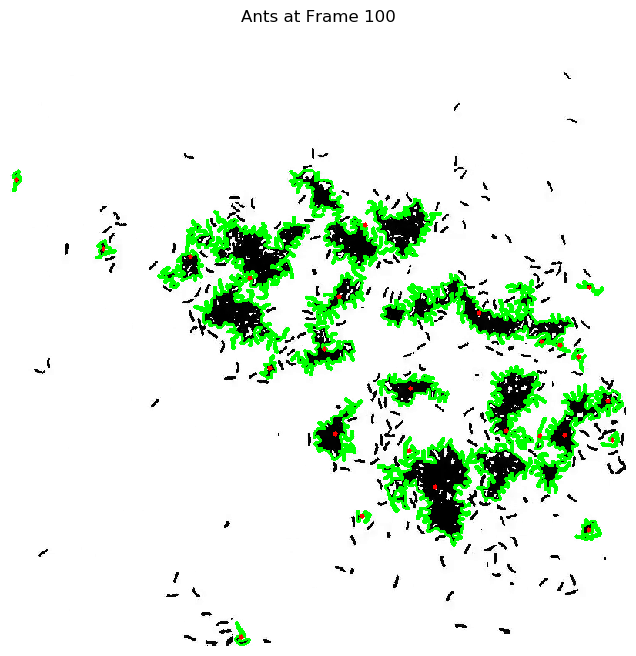

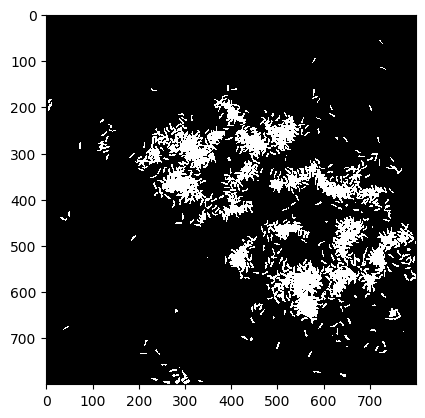

In [129]:
# Open the video file
video_file = 'aggregation.mp4'
cap = cv2.VideoCapture(video_file)

if not cap.isOpened:
    print("Error opening video file")

frame_num=100
current_frame=0

while True:
    ret, frame = cap.read()
    current_frame += 1
    
    if not ret or current_frame == frame_num:
        break
    
# Release the video capture
cap.release()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
inverted_gray = inverted_gray = 255-gray
_, thresholded = cv2.threshold(inverted_gray, 128, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours and centroids on the original frame
frame_with_contours = frame.copy()

min_contour_area = 100  # Adjust this value based on your needs
centroids = []
for contour in contours:
    # Calculate the area of each contour
    contour_area = cv2.contourArea(contour)

    # Check if the contour area is within the specified range
    if min_contour_area <= contour_area:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        centroids.append([cX,cY])

#         # Calculate the orientation angle of the ant (major axis)
#         _, _, angle = cv2.fitEllipse(contour)
#         angles.append(angle)

#         # Convert the angle from degrees to radians
#         angle_rad = np.deg2rad(angle)

#         # Calculate the endpoint of the arrow based on the orientation
#         arrow_length = 50  # Length of the arrow
#         endpoint_x = int(cX - arrow_length * np.sin(angle_rad))
#         endpoint_y = int(cY + arrow_length * np.cos(angle_rad))  # Negative sin because of image coordinates

#         # Draw the arrow from centroid to endpoint
#         cv2.arrowedLine(frame_with_contours, (cX, cY), (endpoint_x, endpoint_y), (0, 255, 0), 2)

        # Draw the contour and centroid on the frame
        cv2.drawContours(frame_with_contours, [contour], 0, (0, 255, 0), 2)  # Green contour
        cv2.circle(frame_with_contours, (cX, cY), 3, (0, 0, 255), -1)  # Red centroid

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frame_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f'Ants at Frame {frame_num}')
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))
plt.show()

## Tuning Parameters for Ant Detection

In [71]:
# Code to tune parameters on minimum contour area and thresholding.

# Open the video file
video_file = 'aggregation.mp4'
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    print("Error opening video file")
    
# Set minimum contour areas to filter ants
min_contour_area = 25  # Adjust this value based on your needs

max_frame_num = 40

num_ants = []
current_frame=0
while True:
    # Read a frame from the video
    ret, frame = cap.read()
    current_frame += 1

    # Break the loop if we've reached the end of the video or the desired frame
    if not ret or current_frame >= max_frame_num:
        break

    # Convert the frame to grayscale for contour detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    inverted_gray = 255-gray
    _, thresholded = cv2.threshold(inverted_gray, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the grayscale frame
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = []
    for contour in contours:
        # Calculate the area of each contour
        contour_area = cv2.contourArea(contour)

        # Check if the contour area is within the specified range
        if min_contour_area <= contour_area:
            areas.append(contour_area)
    num_ants.append(len(areas))
    
print(f"Min: {min(num_ants)}, Max: {max(num_ants)}, Avg: {np.mean(num_ants)}")
print(num_ants)

Min: 408, Max: 696, Avg: 589.8775510204082
[408, 458, 449, 442, 464, 474, 451, 473, 485, 501, 492, 513, 527, 549, 544, 569, 564, 595, 611, 605, 618, 620, 606, 617, 618, 651, 639, 638, 641, 661, 664, 669, 671, 670, 662, 671, 679, 696, 672, 668, 660, 647, 647, 664, 660, 647, 630, 550, 594]


From the above test it seems like the thresholding value has little impact on ant detection, probably because the video was already in black and white. However, the minimum contour area does have a large impact on ant detection. The ideal min is likely around 5, since this maximizes the number of ants detected.

## Trying out Clustering Ants

In [132]:
from sklearn.cluster import DBSCAN
import numpy as np

Estimated number of clusters: 2


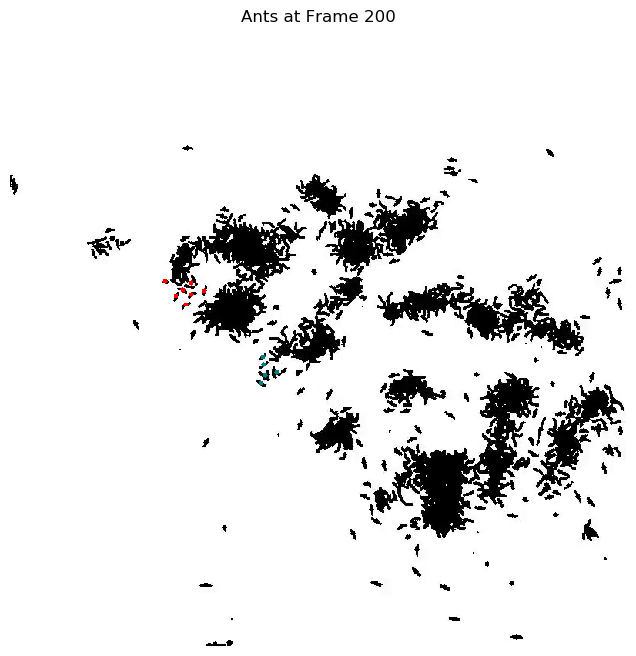

In [122]:
# Open the video file
video_file = 'aggregation.mp4'
cap = cv2.VideoCapture(video_file)

if not cap.isOpened:
    print("Error opening video file")

frame_num=200
current_frame=0

while True:
    ret, frame = cap.read()
    current_frame += 1
    
    if not ret or current_frame == frame_num:
        break
    
# Release the video capture
cap.release()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
inverted_gray = inverted_gray = 255-gray
_, thresholded = cv2.threshold(inverted_gray, 128, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours and centroids on the original frame
frame_with_clusters = frame.copy()

min_contour_area = 5  # Adjust this value based on your needs
centroids = []
for contour in contours:
    # Calculate the area of each contour
    contour_area = cv2.contourArea(contour)

    # Check if the contour area is within the specified range
    if min_contour_area <= contour_area:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        centroids.append([cX,cY])
        
        

# X = np.array(centroids)
# db = DBSCAN(eps=25, min_samples=5).fit(X)
# labels = db.labels_

# # Get the indices of core samples
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# # Number of clusters in labels, ignoring noise if present
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# # Print the number of clusters
# print('Estimated number of clusters: %d' % n_clusters_)

# color_map = {0: (128,128,0),
#              1: (0,0,255),
#              2: (0,255,0),
#              3: (255,0,0),
#              4: (255,255,0),
#              5: (255,0,255),
#              6: (0,255,255),
#              7: (128,0,0),
#              8: (0,128,0),
#              9: (0,0,128)}
# for idx,c in enumerate(labels):
#     if(c == -1):
#         cv2.circle(frame_with_clusters, (X[idx][0], X[idx][1]), 3, (0,0,0), -1)
#         continue
#     if(c > 9):
#         cv2.circle(frame_with_clusters, (X[idx][0], X[idx][1]), 3, (128,128,128), -1)
#         continue
#     cv2.circle(frame_with_clusters, (X[idx][0], X[idx][1]), 3, color_map[c], -1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frame_with_clusters, cv2.COLOR_BGR2RGB))
plt.title(f'Ants at Frame {frame_num}')
plt.axis('off')
plt.show()

The above didn't work. Ants get too clustered up and so cannot be contoured correctly. This results in a bad clustering.

## Trying to use the Watershed Algorithm

In [134]:
from scipy import ndimage

[(305.7506435558607, 349.788742062811), (363.58255451713393, 441.74454828660436), (373.4214559386973, 418.7605363984674), (397.8859060402685, 612.413870246085), (477.12017864393016, 671.2318311002842), (517.2352465642684, 700.2966855295068), (529.1455399061033, 605.4929577464789), (578.640089418778, 587.4988822652757), (553.2893401015228, 618.3756345177665), (571.9427083333334, 656.8142361111111), (580.0102564102564, 642.1179487179487)]


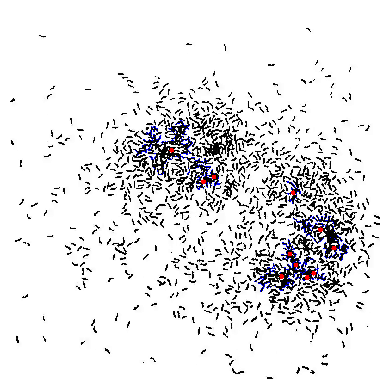

In [148]:
# Open the video file
video_file = 'aggregation.mp4'
cap = cv2.VideoCapture(video_file)

if not cap.isOpened:
    print("Error opening video file")

frame_num=25
current_frame=0

while True:
    ret, frame = cap.read()
    current_frame += 1
    
    if not ret or current_frame == frame_num:
        break
    
# Release the video capture
cap.release()

frame_copy = frame.copy()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
inverted_gray = inverted_gray = 255-gray
_, thresholded = cv2.threshold(inverted_gray, 128, 255, cv2.THRESH_BINARY)

# Find sure background area
dilated = cv2.dilate(thresholded, None, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(thresholded, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(dilated, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
cv2.watershed(frame_copy, markers)
frame_copy[markers == -1] = [255, 0, 0]

# Calculate centroids of the blobs
labels, _ = ndimage.label(markers > 1)
centroids = ndimage.measurements.center_of_mass(markers > 1, labels, range(1, labels.max()+1))

print(centroids)

for centroid in centroids:
    cv2.circle(frame_copy, (int(centroid[1]),int(centroid[0])), 5, (0, 0, 255), -1)  # Red centroid

# plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [3]:
from moviepy.editor import ImageSequenceClip

ModuleNotFoundError: No module named 'moviepy'